# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Random Forest

In [1]:
import os
import joblib
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', UndefinedMetricWarning)

In [2]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.npz' % pathogen)
        data = np.load(f_in)
        X.append(data['X'])
        y.append(data['y'])
    
    # Combine features (X) and labels (y)
    X = np.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [35]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)

In [5]:
# Define scoring and objective functions

## Scoring function
def get_score(params):
    clf = RandomForestClassifier(**params,
                                 n_estimators=50,
                                 class_weight='balanced',
                                 n_jobs=4,
                                 random_state=7)
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1')
    return score.mean()

## Objective function
def f(params):
    score = get_score(params)
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', list(range(10, 101)) + [None]),
    'max_features': hp.choice('max_features', range(10, 101)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 151)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 101))
}

# Begin optimization
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=20, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)

100%|██████████| 20/20 [26:38<00:00, 72.32s/it, best loss: -0.5236213175348314]


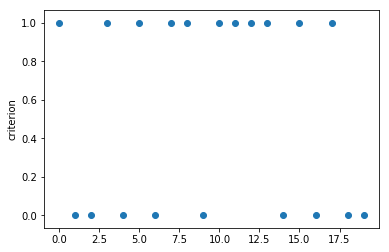

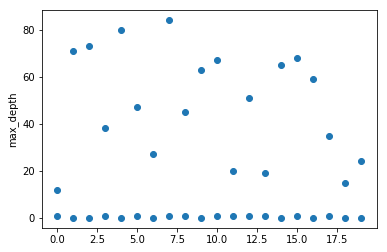

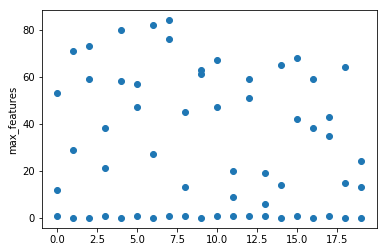

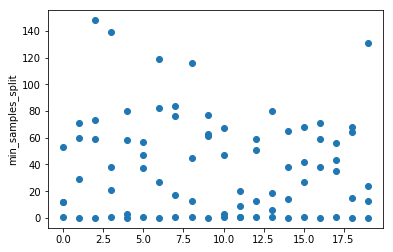

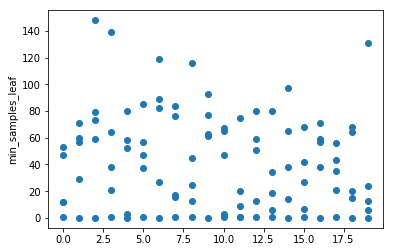

In [22]:
x=[]
y=[]

# Plot trials for each parameter
for param in param_space.keys():

    for t in trials.trials:
        x.append(t['tid'])
        y.append(t['misc']['vals'][param])
    
    _ = plt.ylabel(param)
    _ = plt.scatter(x, y)
    _ = plt.show()

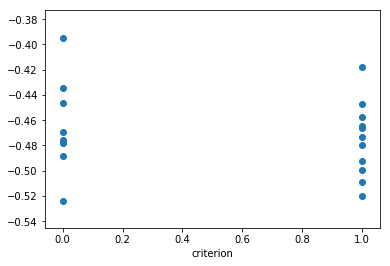

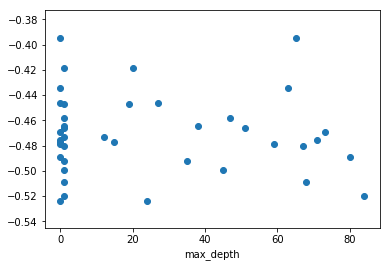

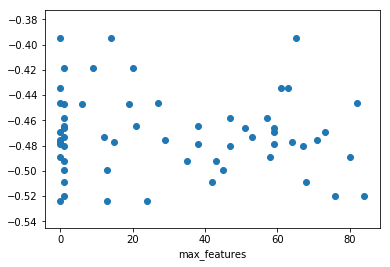

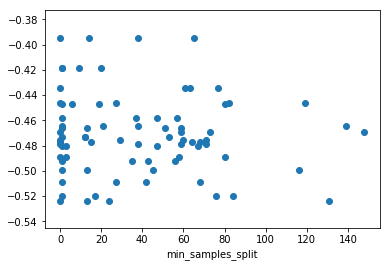

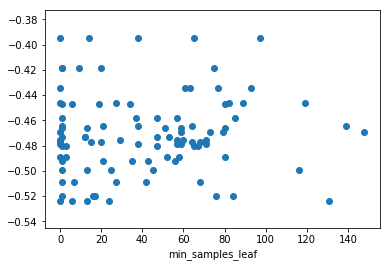

In [23]:
# Plot loss vs parameter value
x=[]
y=[]

for param in param_space.keys():
    for t in trials.trials:
        x.append(t['misc']['vals'][param])
        y.append(t['result']['loss'])
    
    _ = plt.xlabel(param)
    _ = plt.scatter(x, y)
    _ = plt.show()

In [36]:
# Set up classifier
best_params
clf = RandomForestClassifier(**best_params,
                             n_estimators=500,
                             class_weight='balanced',
                             n_jobs=4,
                             random_state=7)
#clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=4, random_state=7)
_ = clf.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'RF_best.pkl')

{'criterion': 'gini',
 'max_depth': 34,
 'max_features': 23,
 'min_samples_leaf': 7,
 'min_samples_split': 133}

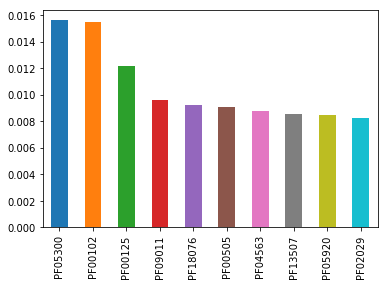

In [37]:
# Examine feature importances
## Get feature names (Pfam accessions)
pfam = joblib.load('pfam.pkl')[1]

feat_importances = pd.Series(clf.feature_importances_,
                             index=pfam)
_ = feat_importances.nlargest(10).plot(kind='bar')

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9120    0.6763    0.7767     10777
           1     0.3714    0.7457    0.4958      2764

    accuracy                         0.6905     13541
   macro avg     0.6417    0.7110    0.6363     13541
weighted avg     0.8017    0.6905    0.7194     13541



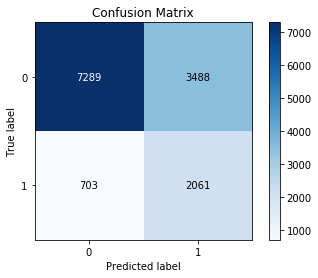

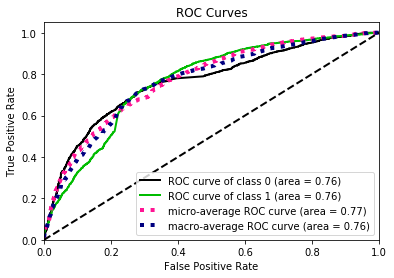

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.8492    0.8424    0.8458     13137
           1     0.4396    0.4524    0.4459      3590

    accuracy                         0.7587     16727
   macro avg     0.6444    0.6474    0.6458     16727
weighted avg     0.7613    0.7587    0.7600     16727



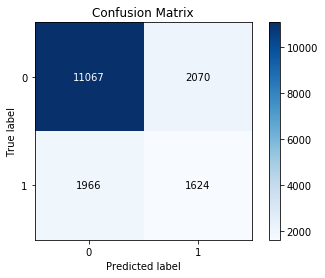

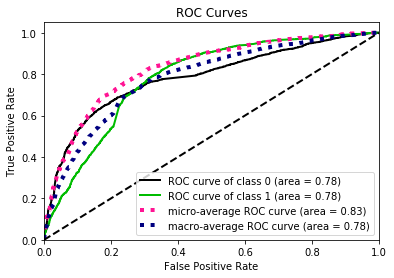

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9314    0.6831    0.7882      3500
           1     0.4769    0.8517    0.6114      1187

    accuracy                         0.7258      4687
   macro avg     0.7042    0.7674    0.6998      4687
weighted avg     0.8163    0.7258    0.7434      4687



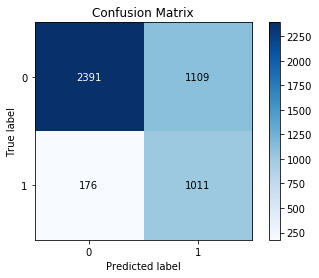

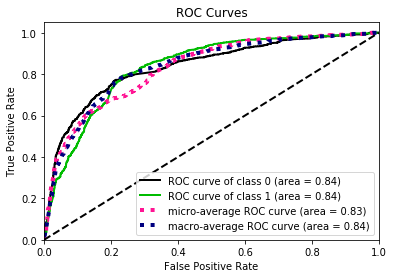

<hr></hr>

In [38]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X, y = get_dataset(p_train)
    
    # Train classifier
    _ = clf.fit(X, y)
    
    # Evaluate performance on test set
    X, y = get_dataset([p_test])
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)
    
    del X
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y, y_pred)
    _ = plot_roc(y, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))